<center> <h1>  Assignment 8 -  week 13 </h1> </center>
<center> <h3> George Adamov </h3> </center>
<center> <h3> HU Matr.Nr.: 543602 (M.Sc. Statistics) </h3> </center>
<center> <h3> CoLab Username: zito </h3> </center>

# **Code**

## **Active Learning - MNIST**



In [0]:
import os, time, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



In [0]:
# split the data
trainset_size = 60000
max_queried = 500


def download():
 mnist = fetch_openml('mnist_784')
 X = mnist.data
 y = mnist.target.astype('float64')  # fetch_openml() returns targets as strings
 print ('MNIST:', X.shape, y.shape)
 return (X, y)

def split(train_size):
 X_train_full = X[:train_size]
 y_train_full = y[:train_size]
 X_test = X[train_size:]
 y_test = y[train_size:]
 return (X_train_full, y_train_full, X_test, y_test)

In [0]:
# 'BaseModel' is a base model for the class architecture, you can implement new models and use them interchangeably

class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)




class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)


class NBModel(BaseModel):

    model_type = 'Multinomial Naive Bayes'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training Naive Bayes  ...')
        self.classifier = MultinomialNB()
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

In [0]:
# 'TrainModel' class accepts one of the previously in defined learning algorithms,
#  trains using the training set and gets performance measurements from the test set.

class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print("Accuracy rate for classification rate of: %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
       # print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print("F1 Score : %f" % metrics.f1_score(y_test, self.test_y_predicted, average='macro'))
        print('--------------------------------')

In [0]:
# 'BaseSelectionFunction' is a base class for various sample selection methods.
#  current implementations include random-selection,  margin sampling-selection 

class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)
        return selection

      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection

In [0]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test)

In [0]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

In [0]:
# - select 'k' random samples, 
# - train a model, 
# - select the most informative samples, 
# - remove from the validation set, 
# - query their labels 
# - and retrain using those samples until reaching the stop criteria.


class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]


        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)


        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)

In [10]:
(X, y) = download()
(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def pickle_load(fname):
  print(os.getcwd(), os.listdir())
  file = open(fname,'rb')
  data = pickle.load(file)
  file.close()
  print(data)
  return data
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d


max_queried = 500 

repeats = 1

models = [NBModel, SvmModel, RfModel] 

selection_functions = [RandomSelection, MarginSamplingSelection] 

Ks = [250,100,25] 

d = {}
stopped_at = -1 


d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)

MNIST: (70000, 784) (70000,)
train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10
stopping at: 500
Count = 1, using model = NBModel, selection_function = RandomSelection, k = 250, iteration = 0.

initial random chosen samples (250,)
initial train set: (250, 784) (250,) unique(labels): [26 26 22 24 31 26 19 31 19 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training Naive Bayes  ...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Accuracy rate for classification rate of: 75.470000 
Classification report for classifier MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True):
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       980
         1.0       0.69      0.82      0.74      1135
         2.0       0.88      0.73      0.80      1032
         3.0       0.79  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59975,) [0. 0. 0. ... 3. 4. 0.]
probabilities: (59975, 9) 
 [0 0 0 ... 0 4 0]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [9 6 6 7 3 3 3 6 2 5] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Accuracy rate for classification rate of: 68.430000 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

         0.0       0.56      0.95      0.71       980
         1.0       0.62      0.99      0.77      1135
         2.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val predicted: (59975,) [1. 0. 4. ... 1. 4. 0.]
probabilities: (59975, 9) 
 [1 0 4 ... 1 4 0]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [8 7 4 9 5 2 6 4 3 2] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Accuracy rate for classification rate of: 56.250000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimator

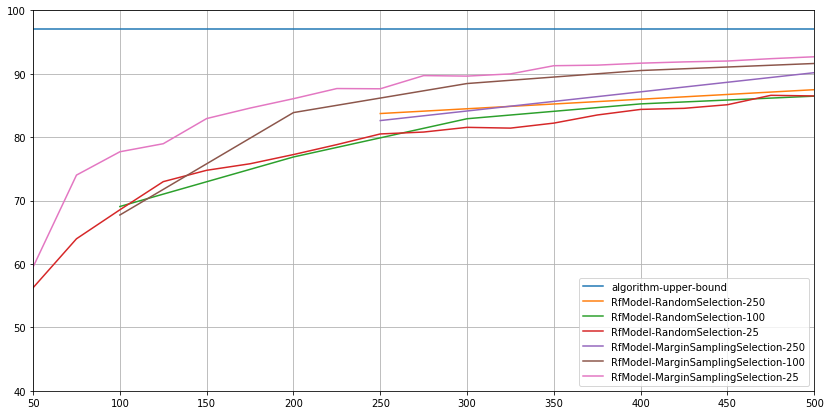

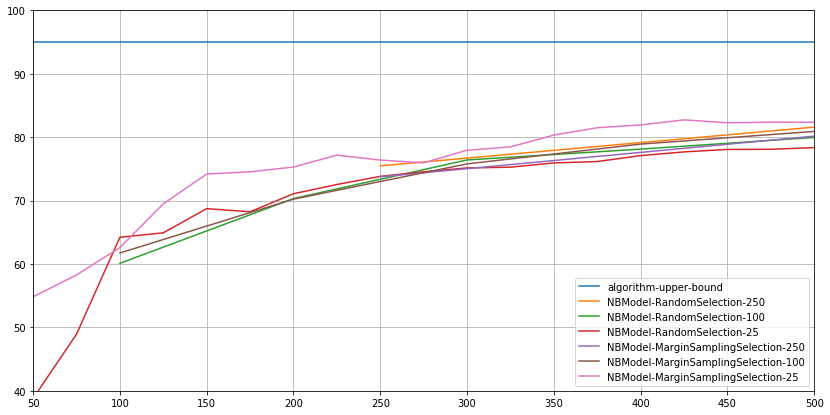

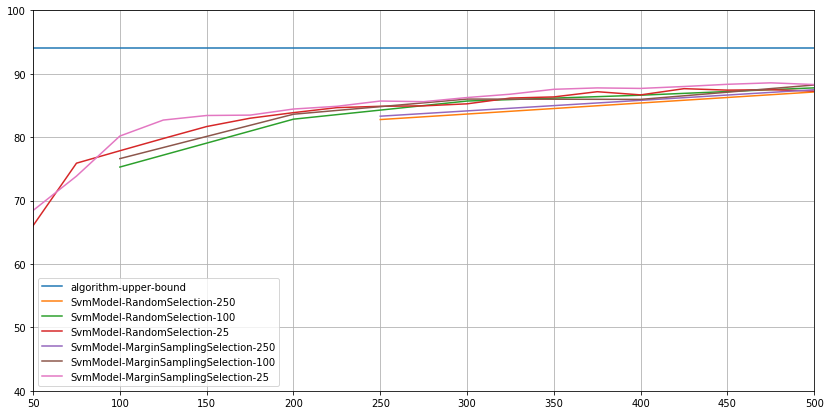

In [19]:
# plots

def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend()
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.show()

models_str = ['NBModel','RfModel','SvmModel'] #['SvmModel', 'RfModel', 'LogModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection']
Ks_str = ['250','100','25'] 
repeats = 1
random_forest_upper_bound = 97.
naive_bayes_bound = 95
svm_upper_bound = 94.
log_upper_bound = 92.47
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats


performance_plot(random_forest_upper_bound, d, ['RfModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(naive_bayes_bound, d, ['NBModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(svm_upper_bound, d, ['SvmModel'] , selection_functions_str    , Ks_str, 1)

## **Supervised Learning -  MNIST**

In [3]:
# prepare the data
trainset_size = 60000

mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype('float64') 
(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

scaler = MinMaxScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test  = scaler.transform(X_test)


train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10


In [13]:
# naive bayes
bayes_clf = MultinomialNB()
bayes_clf.fit(X_train_full, y_train_full)
y_pred = bayes_clf.predict(X_test)
print("Accuracy Naive Bayes: ", accuracy_score(y_test, y_pred))
print("F1 Score Naive Bayes: ", f1_score(y_test, y_pred, average='macro'))

Accuracy Naive Bayes:  0.8357
F1 Score Naive Bayes:  0.8342123721010664


In [0]:
# linear SVC - it runs FOREVER !
linear_svc = SVC(C=1, kernel='linear', probability=True, class_weight='balanced')
linear_svc.fit(X_train_full, y_train_full)
y_pred = linear_svc.predict(X_test)
print("Accuracy SVC: ", accuracy_score(y_test, y_pred))
print("F1 Score SVC: ", f1_score(y_test, y_pred, average='macro'))

In [4]:
# random forest
forest_clf = RandomForestClassifier(n_estimators=50, class_weight='balanced')
forest_clf.fit(X_train_full, y_train_full)
y_pred = forest_clf.predict(X_test)
print("Accuracy Random Forest: ", accuracy_score(y_test, y_pred))
print("F1 Score Random Forest: ", f1_score(y_test, y_pred, average='macro'))

Accuracy Random Forest:  0.9671
F1 Score Random Forest:  0.9667791494099767


## **Supervised Learning - Wine Data**

In [0]:
from sklearn.datasets import load_wine
features, target = load_wine(return_X_y=True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30)

In [0]:
msc = MinMaxScaler()
msc.fit(X_train)
X_train = msc.transform(X_train)
X_test = msc.transform(X_test)

In [19]:
# naive bayes
bayes_clf = MultinomialNB()
bayes_clf.fit(X_train, y_train)
y_pred = bayes_clf.predict(X_test)
print("Accuracy Naive Bayes: ", accuracy_score(y_test, y_pred))
print("F1 Score Naive Bayes: ", f1_score(y_test, y_pred, average='macro'))

# linear svc
linear_svc = SVC(C=1, kernel='linear', probability=True, class_weight='balanced')
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
print("Accuracy SVC: ", accuracy_score(y_test, y_pred))
print("F1 Score SVC: ", f1_score(y_test, y_pred, average='macro'))


# random forest
forest_clf = RandomForestClassifier(n_estimators=50, class_weight='balanced')
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)
print("Accuracy Random Forest: ", accuracy_score(y_test, y_pred))
print("F1 Score Random Forest: ", f1_score(y_test, y_pred, average='macro'))

Accuracy Naive Bayes:  0.9629629629629629
F1 Score Naive Bayes:  0.9645191409897292
Accuracy SVC:  1.0
F1 Score SVC:  1.0
Accuracy Random Forest:  1.0
F1 Score Random Forest:  1.0


# **Active Learning - Wine Data**

In [0]:
# split the data
trainset_size = 124
max_queried = 500


def download():
 wine = load_wine()
 X = wine.data
 y = wine.target  # fetch_openml() returns targets as strings
 print ('MNIST:', X.shape, y.shape)
 return (X, y)

def split(train_size):
 X_train_full = X[:train_size]
 y_train_full = y[:train_size]
 X_test = X[train_size:]
 y_test = y[train_size:]
 return (X_train_full, y_train_full, X_test, y_test)

In [37]:
trainset_size = 124

(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def pickle_load(fname):
  print(os.getcwd(), os.listdir())
  file = open(fname,'rb')
  data = pickle.load(file)
  file.close()
  print(data)
  return data
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d


max_queried = 50 

repeats = 1

models = [NBModel, SvmModel, RfModel] 

selection_functions = [RandomSelection, MarginSamplingSelection] 

Ks = [50,20,10] 

d = {}
stopped_at = -1 


d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)

train: (124, 13) (124,)
test : (54, 13) (54,)
unique classes 3
train: (124, 13) (124,)
test : (54, 13) (54,)
unique classes 3
stopping at: 50
Count = 1, using model = NBModel, selection_function = RandomSelection, k = 50, iteration = 0.

initial random chosen samples (50,)
initial train set: (50, 13) (50,) unique(labels): [23 27] [0 1]
val set: (74, 13) (74,) (50,)

Train set: (50, 13) y: (50,)
Val   set: (74, 13)
Test  set: (54, 13)
training Naive Bayes  ...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.26      1.00      0.41         6
           2       0.00      0.00      0.00        48

    accuracy                           0.11        54
   macro avg     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1

 (40, 13) (40,) unique(labels): [16 24] [0 1]
val set: (84, 13) (84,)

Train set: (40, 13) y: (40,)
Val   set: (84, 13)
Test  set: (54, 13)
training Naive Bayes  ...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.17      1.00      0.29         6
           2       0.00      0.00      0.00        48

    accuracy                           0.11        54
   macro avg       0.06      0.33      0.10        54
weighted avg       0.02      0.11      0.03        54


F1 Score : 0.095238
--------------------------------
val predicted: (84,) [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1

Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.26      1.00      0.41         6
           2       0.00      0.00      0.00        48

    accuracy                           0.11        54
   macro avg       0.09      0.33      0.14        54
weighted avg       0.03      0.11      0.05        54


F1 Score : 0.137931
--------------------------------
val predicted: (114,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1]
probabilities: (

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1


training svm...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.40      1.00      0.57         6
           2       0.00      0.00      0.00        48

    accuracy                           0.11        54
   macro avg       0.13      0.33      0.19        54
weighted avg       0.04      0.11      0.06        54


F1 Score : 0.190476
--------------------------------
val predicted: (84,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 1
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      1.00      0.21         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 1
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      1.00      0.21         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 2
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.14      1.00      0.24         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 3
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.13      1.00      0.23         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 1
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.13      1.00      0.23         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 2
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.15      1.00      0.27         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 3
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.13      1.00      0.23         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 4
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      1.00      0.21         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 5
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.11      1.00      0.20         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 1
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.15      1.00      0.26         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 1
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.15      1.00      0.26         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 2
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      1.00      0.21         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 3
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.00      0.00      0.00        48

    accuracy                           0.11        54
   macro avg       0.06      0.50      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 1
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.00      0.00      0.00        48

    accuracy                           0.11        54
   macro avg       0.06      0.50      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 2
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.17      1.00      0.29         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 3
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      1.00      0.22         6
           2       0.00      0.00      0.00        48

    accuracy                           0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 4
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.00      0.00      0.00        48

    accuracy                           0.11        54
   macro avg       0.06      0.50      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Iteration: 5
--------------------------------
y-test set: (54,)
Accuracy rate for classification rate of: 11.111111 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.00      0.00      0.00        48

    accuracy                           0.11        54
   macro avg       0.06      0.50      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
